<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
<h1>Deep Learning Project #5<h1>
Amin Abdipour 401133011</h1>
</div>

# Import Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import os.path as op
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
# import cv2
# from google.colab.patches import cv2_imshow
# from PIL import Image
# from torch.utils.data import random_split, DataLoader
# from sklearn.metrics import accuracy_score, confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict With RNN (LSTM)

## 1. Load Data

We have ConnectTimeout error for this section, so Run this Section in VS Code and Load Excel data

In [ ]:
# !pip install git+https://github.com/Glyphack/pytse-client.git
# import pytse_client as tse
# tickers = tse.download(symbols=['فولاد'], write_to_csv=True, adjust=True , include_jdate=True)
# display(tickers['فولاد '])

# indices=tse.download_financial_indexes(symbols=['شاخص كل'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل'])

# indices=tse.download_financial_indexes(symbols=['شاخص كل (هم وزن)'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل (هم وزن)'])

In [ ]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
Foolad = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل.csv')  # Path to the Data folder
All = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل (هم وزن).csv')  # Path to the Data folder
HamVazn = pd.read_csv(dir)
Foolad

,date,open,high,low,adjClose,value,volume,count,yesterday,close,jdate
0,2007-03-11,9.0,10.0,9.0,9.0,889437216900,468077431,7736,9.0,9.0,1385-12-20
1,2007-03-12,10.0,10.0,10.0,10.0,193879458000,100041000,9214,9.0,10.0,1385-12-21
2,2007-03-13,10.0,10.0,9.0,10.0,249241504527,126270939,5862,10.0,10.0,1385-12-22
3,2007-03-14,10.0,10.0,10.0,10.0,51666379451,26705128,1901,10.0,10.0,1385-12-23
4,2007-03-17,9.0,10.0,9.0,9.0,28239006789,14877283,1514,10.0,9.0,1385-12-26
...,...,...,...,...,...,...,...,...,...,...,...
3715,2023-12-30,6280.0,6330.0,6250.0,6280.0,413007029830,65778615,3774,6220.0,6280.0,1402-10-09
3716,2023-12-31,6300.0,6300.0,6180.0,6230.0,498910921170,80066614,3884,6280.0,6190.0,1402-10-10
3717,2024-01-01,6230.0,6230.0,6150.0,6200.0,417831898480,67436187,3320,6230.0,6180.0,1402-10-11
3718,2024-01-02,6180.0,6220.0,6100.0,6160.0,446092828520,72415054,3753,6200.0,6150.0,1402-10-12


## 2. Merge 3 data with Common Dates

In [ ]:
# Find the common dates
common_dates = np.intersect1d(np.intersect1d(Foolad['jdate'].values, All['jdate'].values), HamVazn['jdate'].values)

# Create empty matrices to store the merged data
merged_Foolad = np.zeros(len(common_dates))
merged_All = np.zeros(len(common_dates))
merged_HamVazn = np.zeros(len(common_dates))

# Find the indices of common dates in each matrix
indices_Foolad = np.where(np.isin(Foolad['jdate'].values, common_dates))[0]
indices_All = np.where(np.isin(All['jdate'].values, common_dates))[0]
indices_HamVazn = np.where(np.isin(HamVazn['jdate'].values, common_dates))[0]

mat1 = Foolad['adjClose'].values
mat2 = All['close'].values
mat3 = HamVazn['close'].values

merged_Foolad = mat1[indices_Foolad]
merged_All = mat2[indices_All]
merged_HamVazn = mat3[indices_HamVazn]

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)


# concatenate them
data = np.vstack((merged_Foolad[1:],merged_All[1:],merged_HamVazn[1:],common_dates[1:],labels[:]))

print(data.shape)
data

(5, 2006)


array([[70.0, 68.0, 68.0, ..., 6200.0, 6160.0, 6160.0],
       [64526, 64052, 63951, ..., 2168327, 2158766, 2155235],
       [9893, 9815, 9794, ..., 757994, 755945, 756758],
       ['1393-12-05', '1393-12-06', '1393-12-09', ..., '1402-10-11',
        '1402-10-12', '1402-10-13'],
       [0, 0, 1, ..., 0, 0, 1]], dtype=object)

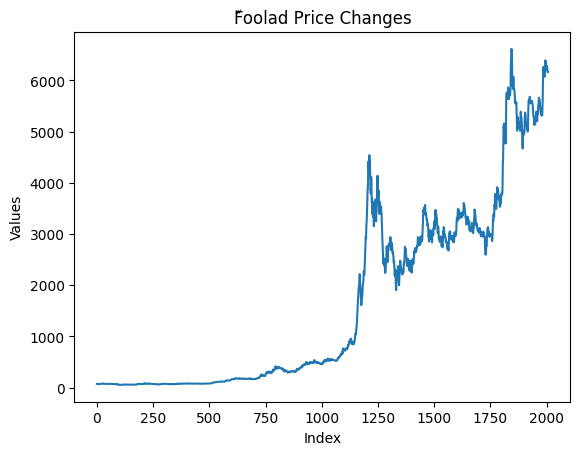

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


x_values = np.arange(len(merged_Foolad))

# Plotting the array
plt.plot(x_values, merged_Foolad)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('ّFoolad Price Changes')
plt.show()



<h2>data[0,:] : Foolad<h2>
data[1,:] : Shakhese Kol <h2>
data[2,:] : Shakhese Ham Vazn <h2>
data[3,:] : Common Dates <h2>
data[4,:] : Labels <h2>


## 3. Normalize Features

In [ ]:
data = data.T
features = data[:, :3].astype(np.float64)  # Convert features to float64
labels = data[:, 4].astype(np.int64)  # Convert labels to int64 for classification

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)


## 4.Create data windows

In [ ]:
def create_windows(data, window_size):
    windows = []
    targets = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size, :3]  # Extract only the first 3 columns (features)
        target = data[i+window_size, -1]  # Extract the label from the last column
        windows.append(window)
        targets.append(target)
    return torch.tensor(windows), torch.tensor(targets, dtype=torch.long)  # Use dtype=torch.long for classification labels


## 5. Split data and adjust window size

In [ ]:
window_size = 5
X, y = create_windows(np.hstack((features, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 6. Define RNN Model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = 3  # 3 features
hidden_size = 50
output_size = 2  # Two classes
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 7. Training

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.684849
Epoch: 2 	Training Loss: 0.683265
Epoch: 3 	Training Loss: 0.681716
Epoch: 4 	Training Loss: 0.680200
Epoch: 5 	Training Loss: 0.678717
Epoch: 6 	Training Loss: 0.677266
Epoch: 7 	Training Loss: 0.675849
Epoch: 8 	Training Loss: 0.674468
Epoch: 9 	Training Loss: 0.673125
Epoch: 10 	Training Loss: 0.671825
Epoch: 11 	Training Loss: 0.670572
Epoch: 12 	Training Loss: 0.669374
Epoch: 13 	Training Loss: 0.668238
Epoch: 14 	Training Loss: 0.667173
Epoch: 15 	Training Loss: 0.666190
Epoch: 16 	Training Loss: 0.665296
Epoch: 17 	Training Loss: 0.664502
Epoch: 18 	Training Loss: 0.663814
Epoch: 19 	Training Loss: 0.663235
Epoch: 20 	Training Loss: 0.662759
Epoch: 21 	Training Loss: 0.662376
Epoch: 22 	Training Loss: 0.662062
Epoch: 23 	Training Loss: 0.661789
Epoch: 24 	Training Loss: 0.661524
Epoch: 25 	Training Loss: 0.661239
Epoch: 26 	Training Loss: 0.660912
Epoch: 27 	Training Loss: 0.660535
Epoch: 28 	Training Loss: 0.660111
Epoch: 29 	Training Loss: 0.6

## 8. Test

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 52.12%


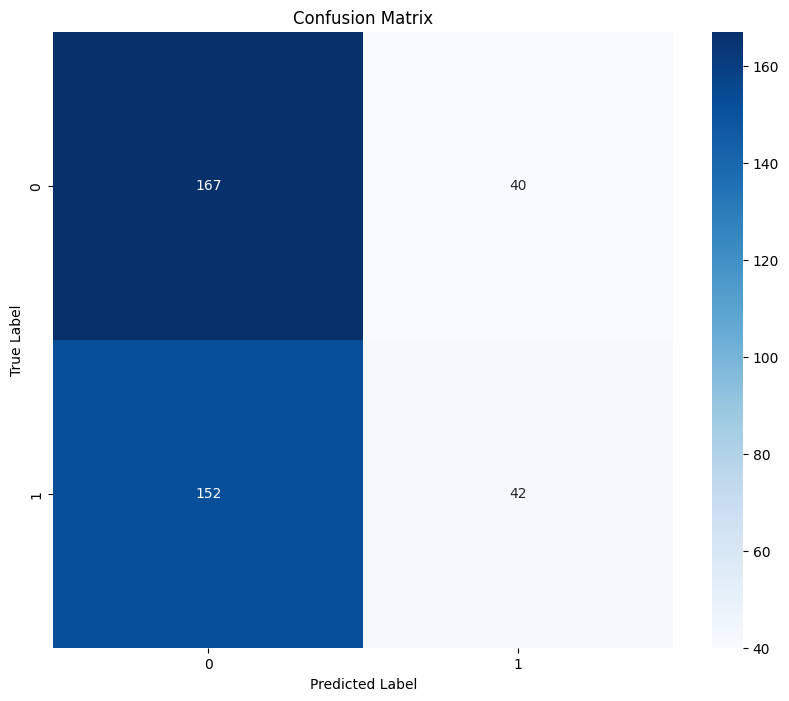

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict with CNN

## 1. Split data and adjust window size

In [ ]:
window_size = 10
X, y = create_windows(np.hstack((features, labels.reshape(-1, 1))), window_size)

# Reshape data for CNN
X = X.unsqueeze(1)

train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 2. Define CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
input_channels = 1
output_size = 2
model = CNN(input_channels, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 3. Training

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))

Epoch: 1 	Training Loss: 0.687024
Epoch: 2 	Training Loss: 0.682560
Epoch: 3 	Training Loss: 0.679183
Epoch: 4 	Training Loss: 0.676332
Epoch: 5 	Training Loss: 0.673855
Epoch: 6 	Training Loss: 0.671560
Epoch: 7 	Training Loss: 0.669318
Epoch: 8 	Training Loss: 0.667153
Epoch: 9 	Training Loss: 0.665072
Epoch: 10 	Training Loss: 0.663038
Epoch: 11 	Training Loss: 0.660944
Epoch: 12 	Training Loss: 0.658765
Epoch: 13 	Training Loss: 0.656714
Epoch: 14 	Training Loss: 0.655112
Epoch: 15 	Training Loss: 0.654093
Epoch: 16 	Training Loss: 0.653809
Epoch: 17 	Training Loss: 0.654118
Epoch: 18 	Training Loss: 0.654771
Epoch: 19 	Training Loss: 0.655420
Epoch: 20 	Training Loss: 0.655726
Epoch: 21 	Training Loss: 0.655557
Epoch: 22 	Training Loss: 0.655034
Epoch: 23 	Training Loss: 0.654408
Epoch: 24 	Training Loss: 0.653862
Epoch: 25 	Training Loss: 0.653466
Epoch: 26 	Training Loss: 0.653253
Epoch: 27 	Training Loss: 0.653216
Epoch: 28 	Training Loss: 0.653310
Epoch: 29 	Training Loss: 0.6

## 4. Test

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()
predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 53.25%


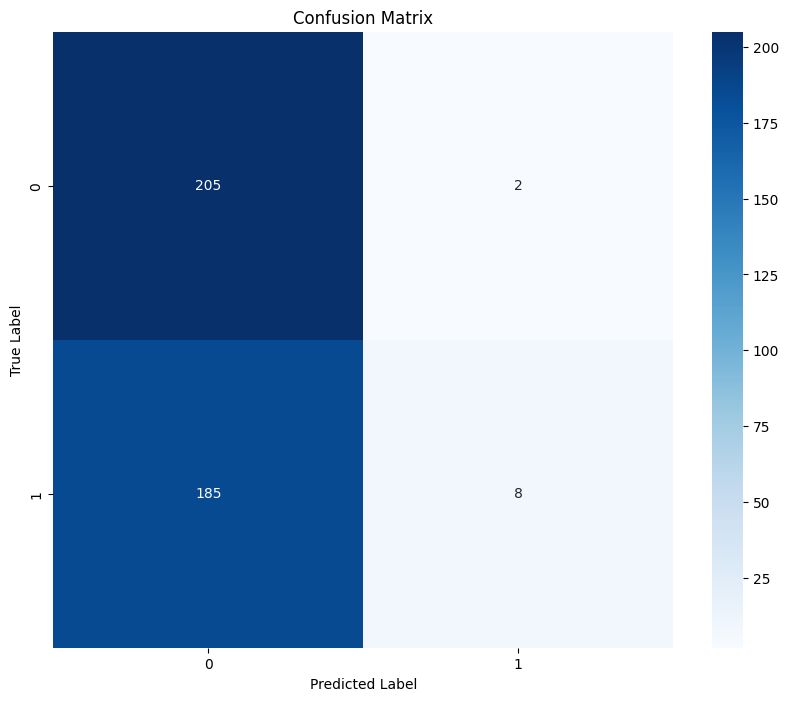

In [ ]:
from sklearn.metrics import confusion_matrix
# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# With Indicator

## without use شاخص کل & شاخص کل(هم وزن)

### 1. Add indicators to Features

In [193]:
pip install pandas-ta

In [194]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
df = pd.read_csv(dir)
aroon = df.ta.aroon(inplace=True)
aroon = aroon['AROONU_14'].values[indices_Foolad].astype(np.float64)
macd = df.ta.macd(inplace=True)
macd = macd['MACD_12_26_9'].values[indices_Foolad].astype(np.float64)
rsi = df.ta.rsi(inplace=True)
rsi = rsi[indices_Foolad].astype(np.float64)

adjClose = df['adjClose'].values[indices_Foolad].astype(np.float64)

features = np.vstack((adjClose[1:],aroon[1:],macd[1:],rsi[1:]))

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)

### 2. Split data and adjust window size

In [195]:
window_size = 5
X, y = create_windows(np.hstack((features.T, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 3. Define RNN Model

In [196]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [197]:
input_size = 4  # 4 features
hidden_size = 50
output_size = 2  # Two classes
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

### 4. Training

In [198]:
num_epochs = 5000
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.736806
Epoch: 2 	Training Loss: 0.729267
Epoch: 3 	Training Loss: 0.722360
Epoch: 4 	Training Loss: 0.715723
Epoch: 5 	Training Loss: 0.709395
Epoch: 6 	Training Loss: 0.703476
Epoch: 7 	Training Loss: 0.697850
Epoch: 8 	Training Loss: 0.692505
Epoch: 9 	Training Loss: 0.687477
Epoch: 10 	Training Loss: 0.682809
Epoch: 11 	Training Loss: 0.678426
Epoch: 12 	Training Loss: 0.674473
Epoch: 13 	Training Loss: 0.670813
Epoch: 14 	Training Loss: 0.667597
Epoch: 15 	Training Loss: 0.664583
Epoch: 16 	Training Loss: 0.661750
Epoch: 17 	Training Loss: 0.659149
Epoch: 18 	Training Loss: 0.656753
Epoch: 19 	Training Loss: 0.654613
Epoch: 20 	Training Loss: 0.652773
Epoch: 21 	Training Loss: 0.651262
Epoch: 22 	Training Loss: 0.650039
Epoch: 23 	Training Loss: 0.649042
Epoch: 24 	Training Loss: 0.648295
Epoch: 25 	Training Loss: 0.647794
Epoch: 26 	Training Loss: 0.647521
Epoch: 27 	Training Loss: 0.647398
Epoch: 28 	Training Loss: 0.647382
Epoch: 29 	Training Loss: 0.6

### 5. Test

In [199]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 51.12%


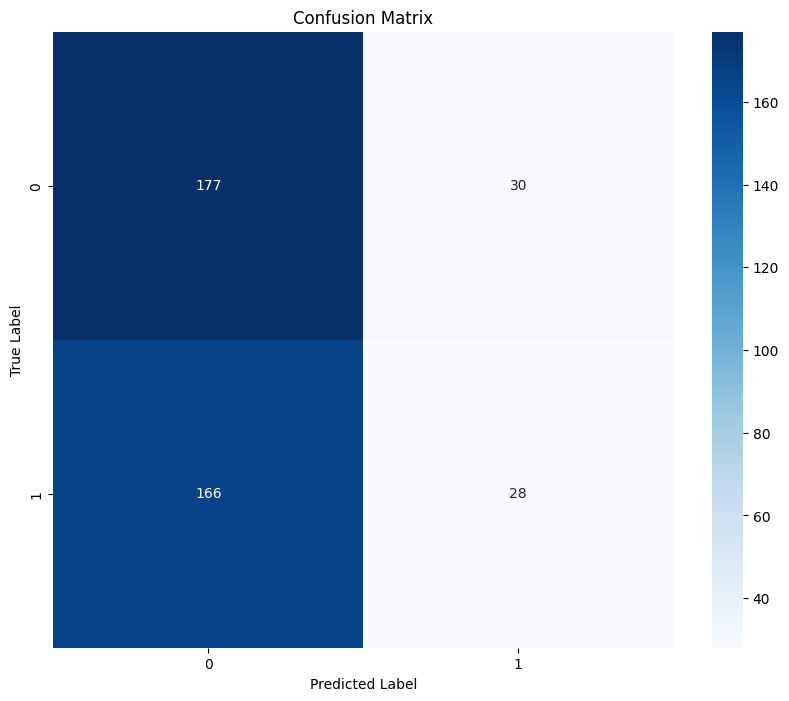

In [200]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## with use شاخص کل

### 1. Add indicators to Features

In [201]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
df = pd.read_csv(dir)
aroon = df.ta.aroon(inplace=True)
aroon = aroon['AROONU_14'].values[indices_Foolad].astype(np.float64)
macd = df.ta.macd(inplace=True)
macd = macd['MACD_12_26_9'].values[indices_Foolad].astype(np.float64)
rsi = df.ta.rsi(inplace=True)
rsi = rsi[indices_Foolad].astype(np.float64)

adjClose = df['adjClose'].values[indices_Foolad].astype(np.float64)

df = All
aroon_all = df.ta.aroon(inplace=True)
aroon_all = aroon_all['AROONU_14'].values[indices_All].astype(np.float64)
macd_all = df.ta.macd(inplace=True)
macd_all = macd_all['MACD_12_26_9'].values[indices_All].astype(np.float64)
rsi_all = df.ta.rsi(inplace=True)
rsi_all = rsi_all[indices_All].astype(np.float64)

close_all = df['close'].values[indices_All].astype(np.float64)

features = np.vstack((adjClose[1:],aroon[1:],macd[1:],rsi[1:],close_all[1:],aroon_all[1:],macd_all[1:],rsi_all[1:]))

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)

In [202]:
features.shape

(8, 2006)

### 2. Split data and adjust window size

In [203]:
window_size = 5
X, y = create_windows(np.hstack((features.T, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 3. Define RNN Model

In [204]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [205]:
input_size = 8  # 8 features
hidden_size = 50
output_size = 2  # Two classes
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

### 4. Training

In [206]:
num_epochs = 5000
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.721856
Epoch: 2 	Training Loss: 0.714767
Epoch: 3 	Training Loss: 0.707852
Epoch: 4 	Training Loss: 0.701611
Epoch: 5 	Training Loss: 0.695966
Epoch: 6 	Training Loss: 0.690766
Epoch: 7 	Training Loss: 0.685799
Epoch: 8 	Training Loss: 0.681520
Epoch: 9 	Training Loss: 0.678068
Epoch: 10 	Training Loss: 0.675152
Epoch: 11 	Training Loss: 0.672652
Epoch: 12 	Training Loss: 0.670265
Epoch: 13 	Training Loss: 0.668003
Epoch: 14 	Training Loss: 0.665860
Epoch: 15 	Training Loss: 0.664279
Epoch: 16 	Training Loss: 0.663153
Epoch: 17 	Training Loss: 0.662080
Epoch: 18 	Training Loss: 0.660950
Epoch: 19 	Training Loss: 0.659731
Epoch: 20 	Training Loss: 0.658411
Epoch: 21 	Training Loss: 0.657062
Epoch: 22 	Training Loss: 0.655836
Epoch: 23 	Training Loss: 0.654801
Epoch: 24 	Training Loss: 0.653856
Epoch: 25 	Training Loss: 0.652999
Epoch: 26 	Training Loss: 0.652111
Epoch: 27 	Training Loss: 0.651201
Epoch: 28 	Training Loss: 0.650387
Epoch: 29 	Training Loss: 0.6

### 5. Test

In [207]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 50.62%


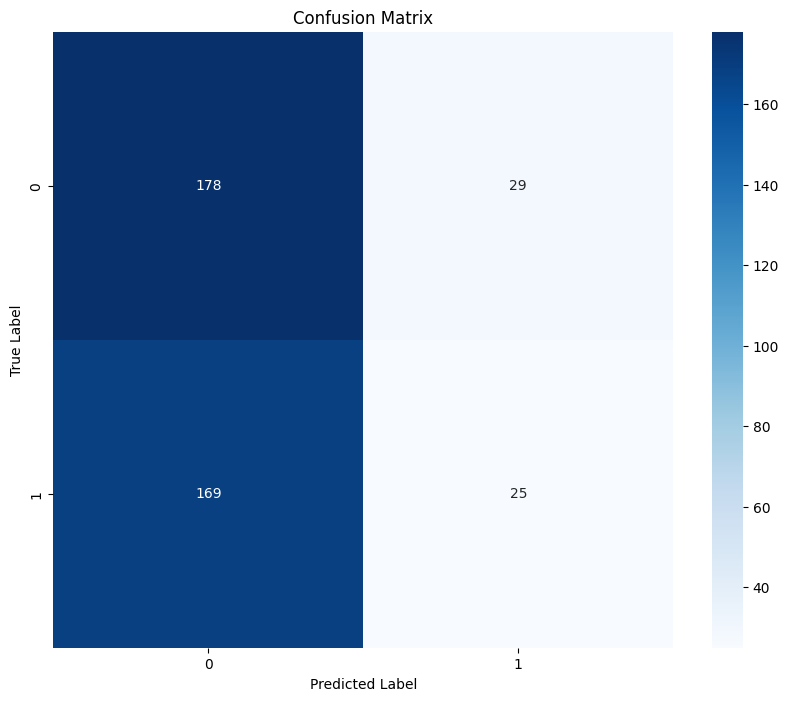

In [208]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## with use شاخص کل(هم وزن)

### 1. Add indicators to Features

In [209]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
df = pd.read_csv(dir)
aroon = df.ta.aroon(inplace=True)
aroon = aroon['AROONU_14'].values[indices_Foolad].astype(np.float64)
macd = df.ta.macd(inplace=True)
macd = macd['MACD_12_26_9'].values[indices_Foolad].astype(np.float64)
rsi = df.ta.rsi(inplace=True)
rsi = rsi[indices_Foolad].astype(np.float64)

adjClose = df['adjClose'].values[indices_Foolad].astype(np.float64)

df = HamVazn
aroon_HamVazn = df.ta.aroon(inplace=True)
aroon_HamVazn = aroon_HamVazn['AROONU_14'].values[indices_HamVazn].astype(np.float64)
macd_HamVazn = df.ta.macd(inplace=True)
macd_HamVazn = macd_HamVazn['MACD_12_26_9'].values[indices_HamVazn].astype(np.float64)
rsi_HamVazn = df.ta.rsi(inplace=True)
rsi_HamVazn = rsi_HamVazn[indices_HamVazn].astype(np.float64)

close_HamVazn = df['close'].values[indices_HamVazn].astype(np.float64)

features = np.vstack((adjClose[1:],aroon[1:],macd[1:],rsi[1:],close_HamVazn[1:],aroon_HamVazn[1:],macd_HamVazn[1:],rsi_HamVazn[1:]))

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)

In [210]:
features.shape

(8, 2006)

### 2. Split data and adjust window size

In [211]:
window_size = 5
X, y = create_windows(np.hstack((features.T, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 3. Define RNN Model

In [212]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [213]:
input_size = 8  # 8 features
hidden_size = 50
output_size = 2  # Two classes
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

### 4. Training

In [214]:
num_epochs = 5000
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.714487
Epoch: 2 	Training Loss: 0.709596
Epoch: 3 	Training Loss: 0.705013
Epoch: 4 	Training Loss: 0.700436
Epoch: 5 	Training Loss: 0.695977
Epoch: 6 	Training Loss: 0.691858
Epoch: 7 	Training Loss: 0.688051
Epoch: 8 	Training Loss: 0.684340
Epoch: 9 	Training Loss: 0.680759
Epoch: 10 	Training Loss: 0.677253
Epoch: 11 	Training Loss: 0.673803
Epoch: 12 	Training Loss: 0.670220
Epoch: 13 	Training Loss: 0.666331
Epoch: 14 	Training Loss: 0.662433
Epoch: 15 	Training Loss: 0.659353
Epoch: 16 	Training Loss: 0.657338
Epoch: 17 	Training Loss: 0.656022
Epoch: 18 	Training Loss: 0.655154
Epoch: 19 	Training Loss: 0.654380
Epoch: 20 	Training Loss: 0.653563
Epoch: 21 	Training Loss: 0.652709
Epoch: 22 	Training Loss: 0.651893
Epoch: 23 	Training Loss: 0.651107
Epoch: 24 	Training Loss: 0.650383
Epoch: 25 	Training Loss: 0.649669
Epoch: 26 	Training Loss: 0.648969
Epoch: 27 	Training Loss: 0.648348
Epoch: 28 	Training Loss: 0.647724
Epoch: 29 	Training Loss: 0.6

### 5. Test

In [215]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[ 1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1
  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1
 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1
  1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 49.38%


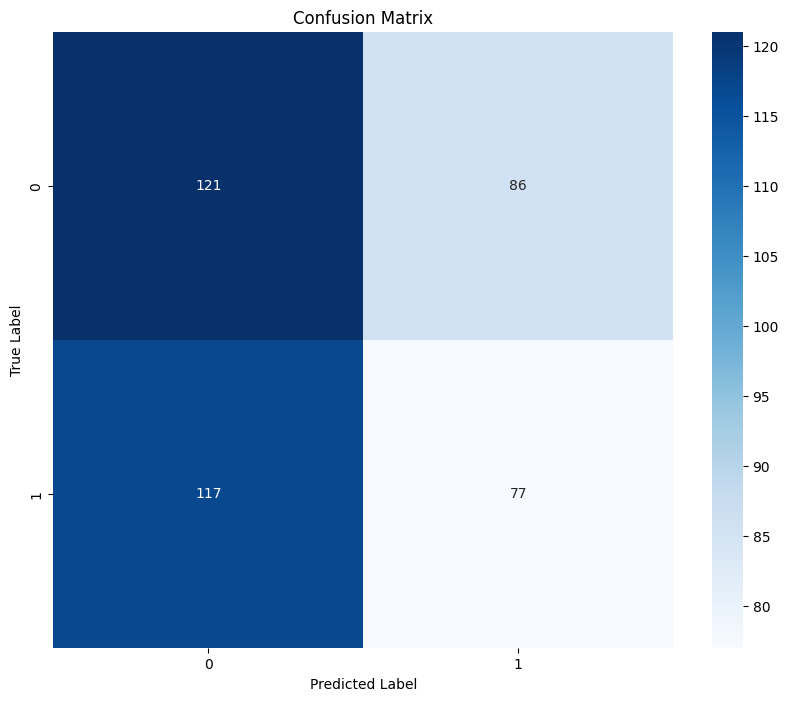

In [216]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## with use شاخص کل & شاخص کل(هم وزن)

### 1. Add indicators to Features

In [217]:
features = np.vstack((adjClose[1:],aroon[1:],macd[1:],rsi[1:],close_all[1:],aroon_all[1:],macd_all[1:],rsi_all[1:],close_HamVazn[1:],aroon_HamVazn[1:],macd_HamVazn[1:],rsi_HamVazn[1:]))

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)

In [218]:
features.shape

(12, 2006)

### 2. Split data and adjust window size

In [219]:
window_size = 5
X, y = create_windows(np.hstack((features.T, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 3. Define RNN Model

In [220]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [221]:
input_size = 12  # 12 features
hidden_size = 50
output_size = 2  # Two classes
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

### 4. Training

In [222]:
num_epochs = 5000
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.668316
Epoch: 2 	Training Loss: 0.665750
Epoch: 3 	Training Loss: 0.663335
Epoch: 4 	Training Loss: 0.661066
Epoch: 5 	Training Loss: 0.658849
Epoch: 6 	Training Loss: 0.656836
Epoch: 7 	Training Loss: 0.654714
Epoch: 8 	Training Loss: 0.653120
Epoch: 9 	Training Loss: 0.651656
Epoch: 10 	Training Loss: 0.650353
Epoch: 11 	Training Loss: 0.649106
Epoch: 12 	Training Loss: 0.648121
Epoch: 13 	Training Loss: 0.647348
Epoch: 14 	Training Loss: 0.646981
Epoch: 15 	Training Loss: 0.646761
Epoch: 16 	Training Loss: 0.646519
Epoch: 17 	Training Loss: 0.646299
Epoch: 18 	Training Loss: 0.646108
Epoch: 19 	Training Loss: 0.645882
Epoch: 20 	Training Loss: 0.645585
Epoch: 21 	Training Loss: 0.645229
Epoch: 22 	Training Loss: 0.644819
Epoch: 23 	Training Loss: 0.644379
Epoch: 24 	Training Loss: 0.643912
Epoch: 25 	Training Loss: 0.643519
Epoch: 26 	Training Loss: 0.643190
Epoch: 27 	Training Loss: 0.642848
Epoch: 28 	Training Loss: 0.642505
Epoch: 29 	Training Loss: 0.6

### 5. Test

In [223]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1  1  1  1
  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Test Accuracy: 48.88%


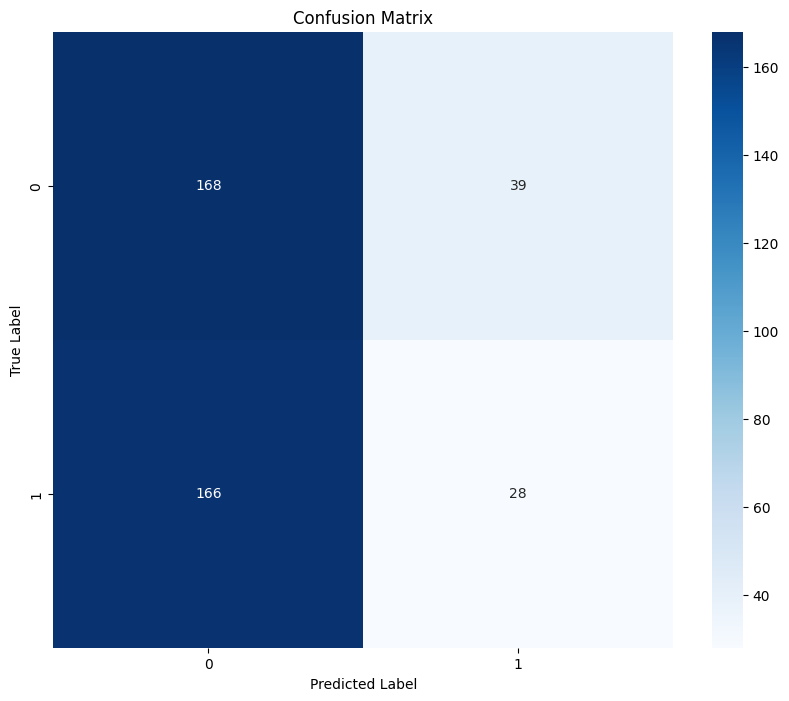

In [224]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# a = np.array(*predicted_labels)
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Anomaly detection using autoencoder

## 1. Load Data

In [251]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','USD.csv')  # Path to the Data folder
USD = pd.read_csv(dir)
X = np.array(USD['last price recorded on the day'])

## 2.Define Model

In [252]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Sigmoid activation for reconstruction in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 3. Split data and adjust layers

In [253]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42,shuffle=False)
train_data = torch.from_numpy(X_train).float()

# Define and train the autoencoder
input_size = 1
hidden_size = 4
model = Autoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

## 4. Train

In [254]:
num_epochs=100
for epoch in range(num_epochs):
    for data in train_loader:
        data = data.float().view(-1, 1)  # Reshape for 1D input
        reconstructions = model(data)
        loss = criterion(reconstructions, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))

Epoch: 1 	Training Loss: 1144763520.000000
Epoch: 2 	Training Loss: 1034111616.000000
Epoch: 3 	Training Loss: 1211212928.000000
Epoch: 4 	Training Loss: 1130698240.000000
Epoch: 5 	Training Loss: 1094131328.000000
Epoch: 6 	Training Loss: 1719138816.000000
Epoch: 7 	Training Loss: 1167155072.000000
Epoch: 8 	Training Loss: 1454562560.000000
Epoch: 9 	Training Loss: 1264586496.000000
Epoch: 10 	Training Loss: 1614127872.000000
Epoch: 11 	Training Loss: 992885184.000000
Epoch: 12 	Training Loss: 1101694080.000000
Epoch: 13 	Training Loss: 1021535808.000000
Epoch: 14 	Training Loss: 1174750336.000000
Epoch: 15 	Training Loss: 1125910144.000000
Epoch: 16 	Training Loss: 1405753472.000000
Epoch: 17 	Training Loss: 1188805120.000000
Epoch: 18 	Training Loss: 1365015296.000000
Epoch: 19 	Training Loss: 1345600128.000000
Epoch: 20 	Training Loss: 1077338368.000000
Epoch: 21 	Training Loss: 1334825600.000000
Epoch: 22 	Training Loss: 1141294208.000000
Epoch: 23 	Training Loss: 2737394688.00000

## 5. Anomaly detection

In [255]:
def detect_anomalies(model, data, threshold):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data.float().view(-1, 1))  # Reshape for 1D input
        mse_loss = nn.MSELoss(reduction='none')(reconstructions, data.float().view(-1, 1))
        mse_loss = mse_loss.mean(dim=1)
    anomalies = mse_loss > threshold
    return anomalies.numpy()

threshold = 0.1
test_data = torch.from_numpy(X_test).float()
anomalies = detect_anomalies(model, test_data, threshold)

print("Anomalies:", anomalies)


Anomalies: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

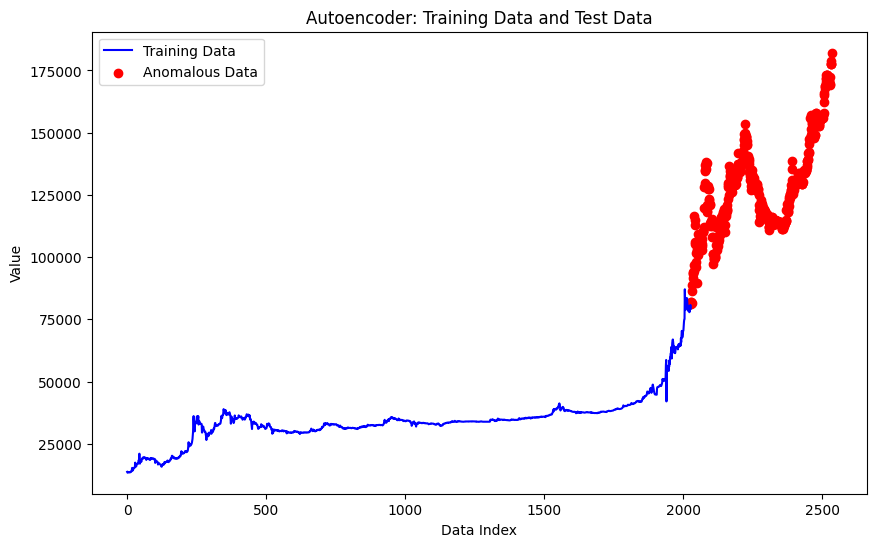

In [256]:
plt.figure(figsize=(10, 6))
# Plot training data
plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')

# Mark anomalies in red
anomalous_indices = np.where(anomalies)[0]
plt.scatter(anomalous_indices + len(train_data), test_data[anomalous_indices].numpy(), label='Anomalous Data', color='red')

plt.title('Autoencoder: Training Data and Test Data')
plt.xlabel('Data Index')
plt.ylabel('Value')
plt.legend()
plt.show()
